# Learing pipeline

Miguel Xochicale [@mxochicale](https://github.com/mxochicale)  
Feb2022


## 1.1 Introduction
This notebook presents prototypes to pre-process echocardiography datasets with the use of pytorch features. 

## 1.2 Running notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
## 1.3 References
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 




## 2. Jupyter Notebook

### 2.1 Setting imports and datasets paths

In [1]:
import os
import sys
import argparse
import yaml
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from IPython.display import HTML #to be used with HTML(animation.ArtistAnimation().to_jshtml())

import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from typing import Dict, List, Tuple

from torch.utils.data import DataLoader
import torch.utils.data as Data
from torchinfo import summary
from torchvision import transforms, utils, models

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset
from source.models.learning_misc import train_loop, test_loop, BasicCNNClassifier, TestNet
from source.helpers.various import concatenating_YAML_via_tags, plot_dataset_classes

HOME_PATH = os.path.expanduser(f'~')
CONFIG_FILES_PATH= 'repositories/echocardiography/scripts/config_files/learning_pipeline'
YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, 'config_learning_pipeline.yml')

yaml.add_constructor('!join', concatenating_YAML_via_tags)  ## register the tag handler

with open(YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)
    
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)    

PyTorch Version:  1.9.0
Torchvision Version:  0.10.0a0


### 2.2 Setting variables and loading datasets using pytorch dataloader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Defining transforms that apply to the entire dataset.
# These transforms are not augmentation.
if config['use_pretransform_image_size']:
    pretransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=config['pretransform_im_size']),
        transforms.ToTensor(),
    ])
else:
    pretransform = None

# These transforms have random parameters changing at each epoch.
if config['use_train_augmentation']:
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),  # in degrees
        transforms.RandomEqualize(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(), 
    ])
else:
    transform = None
    
# These transforms have random parameters changing at each epoch.
if config['use_validation_augmentation']:
    val_transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=5),  # in degrees
    #transforms.RandomEqualize(p=0.5),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ToTensor(), 
    ])
else:
    transform = None


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = EchoClassesDataset(
    main_data_path=config['main_data_path'],
    participant_videos_list=config['participant_videos_list_train'],
    participant_path_json_list=config['participant_path_json_list_train'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    number_of_frames_per_segment_in_a_clip=config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=device,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    pretransform=pretransform,
    transform=train_transform,
    use_tmp_storage=True,
    )


validation_dataset = EchoClassesDataset(
    main_data_path=config['main_data_path'],
    participant_videos_list=config['participant_videos_list_validation'],
    participant_path_json_list=config['participant_path_json_list_validation'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    number_of_frames_per_segment_in_a_clip=config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=device,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    pretransform=pretransform,
    transform=val_transform,
    use_tmp_storage=True,
    )


[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-074/T3/01NVb-003-074-3-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T1/01NVb-003-077-1-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T2/01NVb-003-077-2-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T3/01NVb-003-077-3-4CV.json (empty). Removing from list


### 2.N Plotting Class Distribution


{'BKGR': 36, '4CV': 36}
{'BKGR': 8, '4CV': 8}


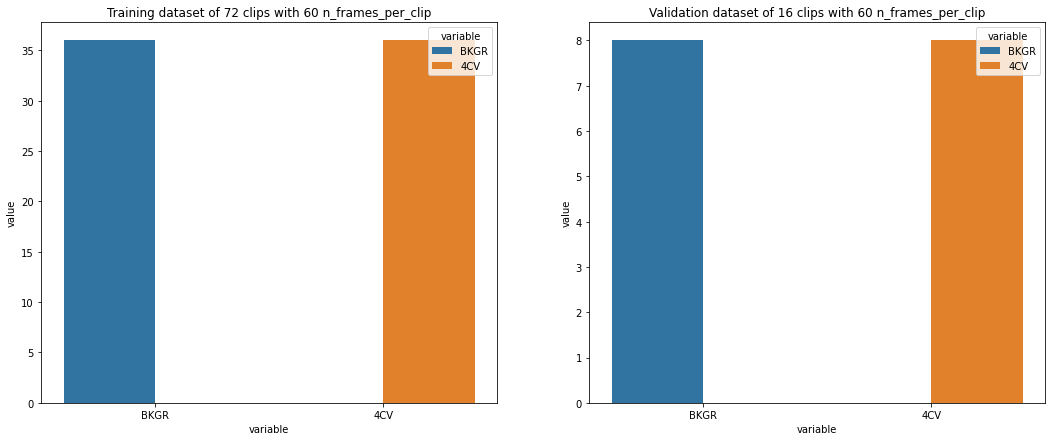

In [3]:
label_id = ('BKGR', '4CV')

number_of_frames_per_segment_in_a_clip = config['number_of_frames_per_segment_in_a_clip'] 


def get_class_distribution(dataset_obj):
    count_class_dict = {
   'BKGR': 0 ,
   "4CV": 0
    }
    
    for clip_index_i in range(len(dataset_obj)):
        data_idx = dataset_obj[clip_index_i]
        label_id_idx = data_idx[1]
        label = label_id[label_id_idx]
        count_class_dict[label]+= 1
        #count_class_dict[label]+= 1* number_of_frames_per_segment_in_a_clip

    return count_class_dict
        
        
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), 
                       x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)



print(get_class_distribution(train_dataset))

print(get_class_distribution(validation_dataset))


plot_title_train_label= f'Training dataset of {len(train_dataset)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'
plot_title_val_label= f'Validation dataset of {len(validation_dataset)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
plot_from_dict(get_class_distribution(train_dataset), plot_title=plot_title_train_label, ax=axes[0])
plot_from_dict(get_class_distribution(validation_dataset), plot_title=plot_title_val_label, ax=axes[1])
plt.show()






### 2.3 Animating frames of one clip of the dataloader

Clip Size of data_clip_idx torch.Size([60, 1, 128, 128]) of BKGR label


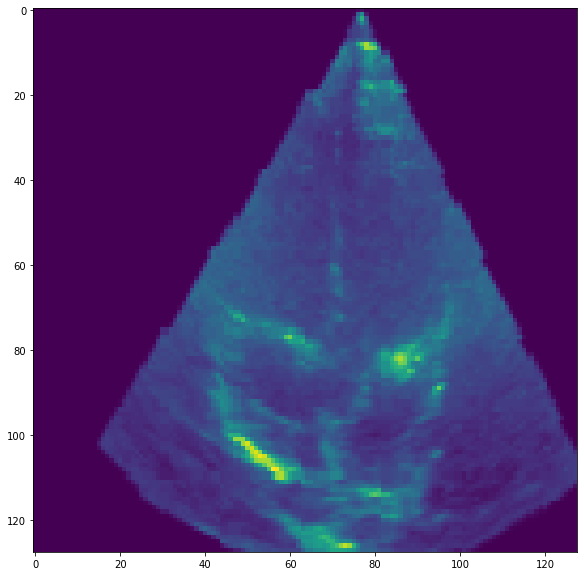

In [4]:
#average_HR =
#fps = 30
# 60 # beats per minute 
#Beats-per-minute: 60 BPM
#Beats-per-second: 1 Hz
#Cycle-per-second: 1 (Cycle/s)

clip_idx = 21
data_clip_idx = train_dataset[clip_idx][0]
data_clip_label = train_dataset[clip_idx][1]
print(f'Clip Size of data_clip_idx {data_clip_idx.size()} of {label_id[data_clip_label]} label')

### Animating data_clip_idx 
interval_between_frames_in_milliseconds=200
fig = plt.figure(figsize=(10, 10))
frames = [[plt.imshow(data_clip_idx[i].cpu().detach().numpy().transpose(1, 2, 0))] for i in range(len(data_clip_idx))]
anim = animation.ArtistAnimation(fig, frames, interval=interval_between_frames_in_milliseconds, blit=True, repeat_delay=1000)

HTML(anim.to_jshtml())

# ### Save animation as gif (if required) or other formats https://holypython.com/how-to-save-matplotlib-animations-the-ultimate-guide/
# f = r"/home/mx19/repositories/echocardiography/scripts/learning-pipeline/animation.gif" 
# writergif = animation.PillowWriter(fps=30) 
# writergif2='imagemagick'
# anim.save(f, dpi=80, writer=writergif)


### 2.4 Displayting frames in the dataloader

In [5]:
BATCH_SIZE_OF_CLIPS = 20

print(f' dataset.__len__() = {train_dataset.__len__()}')

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

print(f' train_dataloader.__len__() = {train_dataloader.__len__()}' )

for clip_batch_idx, sample_batched in enumerate(train_dataloader):
    print(f'----------------------------------------------------------')
    sample_batched_images=sample_batched[0]
    sample_batched_labels=sample_batched[1]
    print(f'   BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
    print(f'   SAMPLE_IDX_LABELS: {  sample_batched_labels  }')
    print(f'   SAMPLE_BATCH: {sample_batched_images.size()}')
    
    sample_batched=sample_batched_images #.squeeze()
    print(f'   SAMPLE_BATCH.squeeze: {sample_batched.size()}')
    
    for BATCH_SIZE_IDX, label in enumerate(sample_batched_labels):
        print(BATCH_SIZE_IDX, label)
        sample_batched_idx_image = sample_batched[BATCH_SIZE_IDX,...]
        print(f'   sample_batched_idx_image.size()  {sample_batched_idx_image.size() }'  )
        
        grid = utils.make_grid(sample_batched_idx_image)
        print(f'   Grid size {grid.size()}' )
#         plt.figure(figsize =(20,20) )
#         plt.imshow( grid.cpu().detach().numpy().transpose(1, 2, 0) )
#         plt.title(f'BATCH_SIZE_IDX {BATCH_SIZE_IDX}; Label: {label_id[label]}')
#         plt.axis('off')
#         plt.ioff()
#         plt.show()



 dataset.__len__() = 72
 train_dataloader.__len__() = 4
----------------------------------------------------------
   BATCH_OF_CLIPS_INDEX: 0 
   SAMPLE_IDX_LABELS: tensor([1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1])
   SAMPLE_BATCH: torch.Size([20, 60, 1, 128, 128])
   SAMPLE_BATCH.squeeze: torch.Size([20, 60, 1, 128, 128])
0 tensor(1)
   sample_batched_idx_image.size()  torch.Size([60, 1, 128, 128])
   Grid size torch.Size([3, 1042, 1042])
1 tensor(1)
   sample_batched_idx_image.size()  torch.Size([60, 1, 128, 128])
   Grid size torch.Size([3, 1042, 1042])
2 tensor(0)
   sample_batched_idx_image.size()  torch.Size([60, 1, 128, 128])
   Grid size torch.Size([3, 1042, 1042])
3 tensor(0)
   sample_batched_idx_image.size()  torch.Size([60, 1, 128, 128])
   Grid size torch.Size([3, 1042, 1042])
4 tensor(1)
   sample_batched_idx_image.size()  torch.Size([60, 1, 128, 128])
   Grid size torch.Size([3, 1042, 1042])
5 tensor(0)
   sample_batched_idx_image.size()  torch.Size([6

## 2.5 Learning lopp

### Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.


In [6]:
LEARNING_RATE = 0.000005
MAX_EPOCHS = 50 #config['max_epochs']

model = BasicCNNClassifier(config['pretransform_im_size']) #print(config['pretransform_im_size']) #(128, 128)
model.to(device)
## PRINT MODEL
print(f'----------------------------------------------------------')
print(model)


### PRINT model.named_parameters
print(f'----------------------------------------------------------')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
    
        
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()



----------------------------------------------------------
BasicCNNClassifier(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=983040, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=2, bias=True)
    (4): Sigmoid()
  )
)
----------------------------------------------------------
classifier.1.weight tensor([[-4.4215e-04,  9.7823e-04,  1.5858e-04,  ..., -3.9558e-04,
          1.2716e-04,  1.7241e-04],
        [-1.2107e-04, -1.8805e-04, -1.8684e-04,  ...,  7.0754e-04,
         -7.1344e-04,  5.3130e-04],
        [ 9.0420e-04, -1.7184e-04,  9.2497e-04,  ..., -6.5141e-04,
          2.8762e-04,  1.8622e-04],
        ...,
        [ 8.9566e-04,  7.5744e-04, -9.1843e-04,  ..., -1.4024e-04,
         -5.9730e-05,  6.1467e-04],
        [-8.6199e-04, -6.0618e-04, -4.8797e-04,  ...,  9.6154e-04,
         -1.2549e-05,  4.8167e-04],
        [ 1.4839e-05,  9.1652e-04,  7.6337e-04,  ..., -1.8894e-04,
         -3.7

In [7]:
### TRAINING
#clip_batch_size = tuple(train_dataloader.dataset.__getitem__(0)[0].shape) ##(60, 1, 128, 128) frames, chs, [width, height]
#print(clip_batch_size)

epoch_loss_values = []
for epoch in range(MAX_EPOCHS):
    print("-" * 10)
    print(f"EPOCH {epoch + 1}/{MAX_EPOCHS}")
    model.train()
    epoch_loss = 0
    step = 0
    
    train_epoch_loss = train_loop(train_dataloader, model, criterion, optimizer, device)
    print(f"Average train epoch loss: {train_epoch_loss:.4f}")

    epoch_loss_values.append(train_epoch_loss)


#print(epoch_loss_values)
    #epoch_loss /= step

    #test_loop(test_dataloader, model_net, loss_function, device)
    
    




----------
EPOCH 1/50
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
Average train epoch loss: 0.7529
----------
EPOCH 2/50
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
Average train epoch loss: 0.6875
----------
EPOCH 3/50
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
Average train epoch loss: 0.6956
----------
EPOCH 4/50
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
Average train epoch loss: 0.6934
----------
EPOCH 5/50
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
Average train epoch loss: 0.6797
----------
EPOCH 6/50
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
Average train epoch loss: 0.6977
----------
EPOCH 7/50
 BATCH_OF_CLIPS_INDEX: 0

<AxesSubplot:>

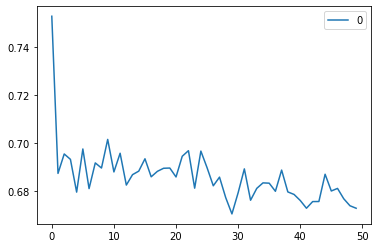

In [8]:
#plt.shown(epoch_loss_values)

train_loss_df = pd.DataFrame.from_dict(epoch_loss_values)
sns.lineplot(data=train_loss_df)

#, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title(f'Train-Val Accuracy/Epoch EPOCHS={EPOCHS} BATCH_SIZE={BATCH_SIZE} LEARNING_RATE={LEARNING_RATE}')
             
             

## BLURS SAMPLERS

# #SubsetRandomSampler(train_idx)
# train_sampler = Data.WeightedRandomSampler(weights=[0.1, 2.0, 3.2, 3.0, 0.6], num_samples=2, replacement=True)
# print( list(train_sampler) )
# #Data.WeightedRandomSampler(weights=samp_weights_v, num_samples = n_output_classes, replacement=True)

# ##Batch size is the number of frames for one segment and those frames can be set to suffle 
# train_dataloader = DataLoader(
#     dataset=data_clip00,
#     batch_size=30,
#     shuffle=False,
#     num_workers=0,
#     pin_memory=False,
#     sampler=train_sampler
#     )

## BLURS MODELS 
#model = TestNet()
##TODO https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
#model = models.vit_l_32(pretrained=False) #has no attribute
#model = models.densenet121(pretrained=False) #has no attribute
#model = models.alexNet(pretrained=False)
#model = models.resnet50(pretrained=True)

